# Transfer Learning Demo

- Creating a base model
- Freezing layers
- Fine-tuning
- Using a model as a layer
- Advanced transfer learning techniques

In [1]:
import numpy as np
import tensorflow as tf

2025-06-27 20:16:25.452384: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## 1. Create Dummy Data

In [2]:
# Generate dummy data
num_samples = 1000
num_features = 20
num_classes = 3

X = np.random.randn(num_samples, num_features)
y = tf.keras.utils.to_categorical(np.random.randint(0, num_classes, num_samples), num_classes)

In [3]:
X.shape, y.shape

((1000, 20), (1000, 3))

In [5]:
X[:1], y[:10]

(array([[-0.89694671,  0.06314789,  0.43149058, -1.89525068,  0.20576637,
         -2.37147837,  0.0731966 ,  0.21661523,  0.36577271,  1.43923005,
         -1.48185916,  0.87830124, -0.79123931, -0.18793053, -0.57139596,
         -0.00378203,  0.226694  , -0.169648  , -0.30977387,  1.39899393]]),
 array([[0., 0., 1.],
        [1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.]]))

## 2. Build a Base Dense Model

This model will act as the "pre-trained" base for transfer learning.

In [6]:
# Build base model
def build_base_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Dense(64, activation='relu')(inputs)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs, name="base_model")
    return model

In [7]:
base_model = build_base_model((num_features,), num_classes)
base_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
base_model.summary()

Model: "base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,523 (13.76 KB)

 Trainable params: 3,523 (13.76 KB)

 Non-trainable params: 0 (0.00 B)

## 3. Train the Base Model

In [8]:
# Train base model
base_model.fit(X, y, epochs=5, batch_size=32, verbose=1)

Epoch 1/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3291 - loss: 1.2018
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3605 - loss: 1.0973
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4169 - loss: 1.0649
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4411 - loss: 1.0590 
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4724 - loss: 1.0369


## 4. Freezing Layers

In [9]:
# Freeze all layers in the base model
for layer in base_model.layers:
    layer.trainable = False

# Check layer status
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_layer, Trainable: False
Layer 1: dense, Trainable: False
Layer 2: dense_1, Trainable: False
Layer 3: dense_2, Trainable: False


## 5. Add a New Head for Transfer Learning

The frozen (base model) -> feature extractor 

and add a new classification head for a new task

In [11]:
# Use base model as feature extractor
inputs = tf.keras.layers.Input(shape=(num_features,))
x = base_model(inputs, training=False)
x = tf.keras.layers.Dense(16, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

transfer_model = tf.keras.Model(inputs, outputs, name="transfer_model")

In [12]:
transfer_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
transfer_model.summary()

Model: "transfer_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 3)              │         3,523 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,638 (14.21 KB)

 Trainable params: 115 (460.00 B)

 Non-trainable params: 3,523 (13.76 KB)

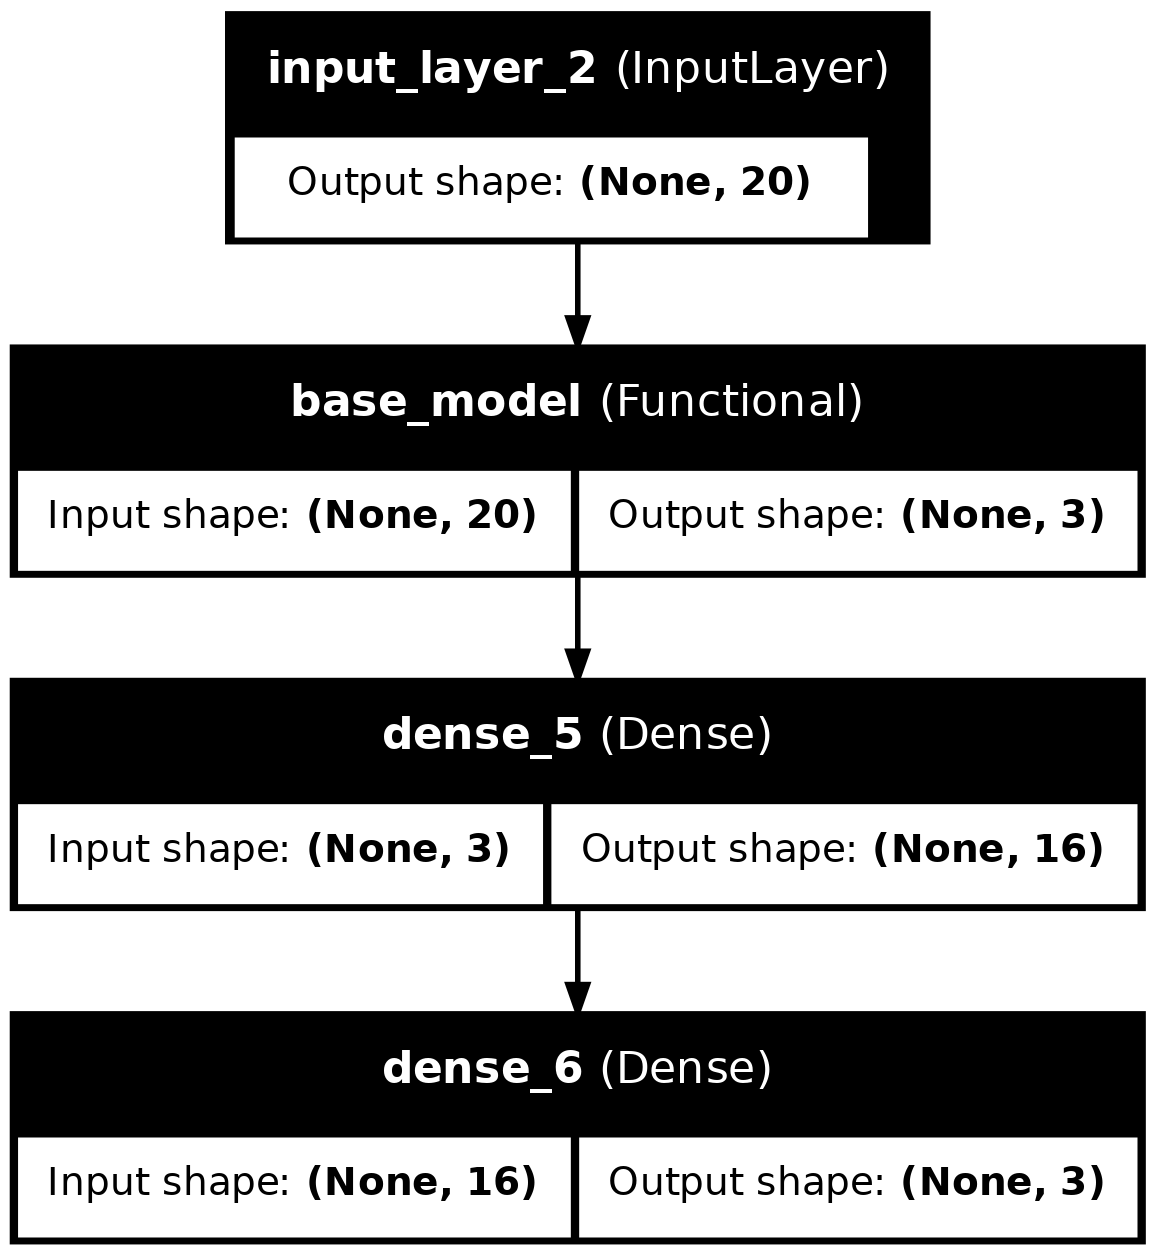

In [14]:
tf.keras.utils.plot_model(transfer_model, to_file='./Data/transfer_model.png', show_shapes=True, show_layer_names=True)

## 6. Train Only the New Head

In [15]:
# Train only the new head
transfer_model.fit(X, y, epochs=5, batch_size=32, verbose=1)

Epoch 1/5


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3547 - loss: 1.1033   
Epoch 2/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3406 - loss: 1.1000
Epoch 3/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.3426 - loss: 1.0977
Epoch 4/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 909us/step - accuracy: 0.4229 - loss: 1.0902
Epoch 5/5
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step - accuracy: 0.4432 - loss: 1.0890


## 7. Fine-Tuning: Unfreeze Some Layers

In [16]:
# Unfreeze the last dense layer of the base model for fine-tuning
for layer in base_model.layers[:-1]:
    layer.trainable = False
base_model.layers[-1].trainable = True

In [17]:
# Recompile the transfer model after changing trainable status
transfer_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy'])

# Fine-tune
transfer_model.fit(X, y, epochs=3, batch_size=32, verbose=1)

Epoch 1/3


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.4188 - loss: 1.0880 
Epoch 2/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4320 - loss: 1.0864
Epoch 3/3
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4436 - loss: 1.0865


## 8. Using a Model as a Layer

In [20]:
# Example: Stack another model on top of the base model
inputs = tf.keras.Input(shape=(num_features,))
x = base_model(inputs)
x = tf.keras.layers.Dense(8, activation='relu')(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
stacked_model = tf.keras.Model(inputs, outputs, name="stacked_model")
stacked_model.summary()

Model: "stacked_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 3)              │         3,523 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 3)              │            27 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,582 (13.99 KB)

 Trainable params: 158 (632.00 B)

 Non-trainable params: 3,424 (13.38 KB)

## 9. Advanced: Partial Freezing and Custom Heads

You can freeze/unfreeze specific layers and add custom heads for different tasks.

In [21]:
# Freeze only the first layer of the base model
base_model.layers[0].trainable = False
for layer in base_model.layers[1:]:
    layer.trainable = True

# Add a custom head
inputs = tf.keras.layers.Input(shape=(num_features,))
x = base_model(inputs)
x = tf.keras.layers.Dense(10, activation='relu')(x)
x = tf.keras.layers.Dropout(0.3)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)
custom_head_model = tf.keras.Model(inputs, outputs, name="custom_head_model")
custom_head_model.summary()

Model: "custom_head_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ base_model (Functional)         │ (None, 3)              │         3,523 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 10)             │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,596 (14.05 KB)

 Trainable params: 3,596 (14.05 KB)

 Non-trainable params: 0 (0.00 B)